## Decision Support System (DSS) Span Analysis ##

https://github.com/jupyter/docker-stacks  
https://hub.docker.com/r/jupyter/r-notebook/tags/  

_(optional) docker pull jupyter/r-notebook:latest_  

We want to make the DDS Prototype ~/analysis/ directory linked to the Juypter container. Use the following to mount the analysis directory (i.e. current working directory) as a volume in the Juypter container. Note that the directory needed to be added via the Docker Desktop Dashboard on Mac.

_docker run -it --rm -d -p 10000:8888 -v ${PWD}:/home/jovyan/work --name notebook jupyter/r-notebook:latest_  

To find the token from the container:  
_docker exec -it notebook jupyter server list_

Navigate to the container UI and enter the token:
http://localhost:10000

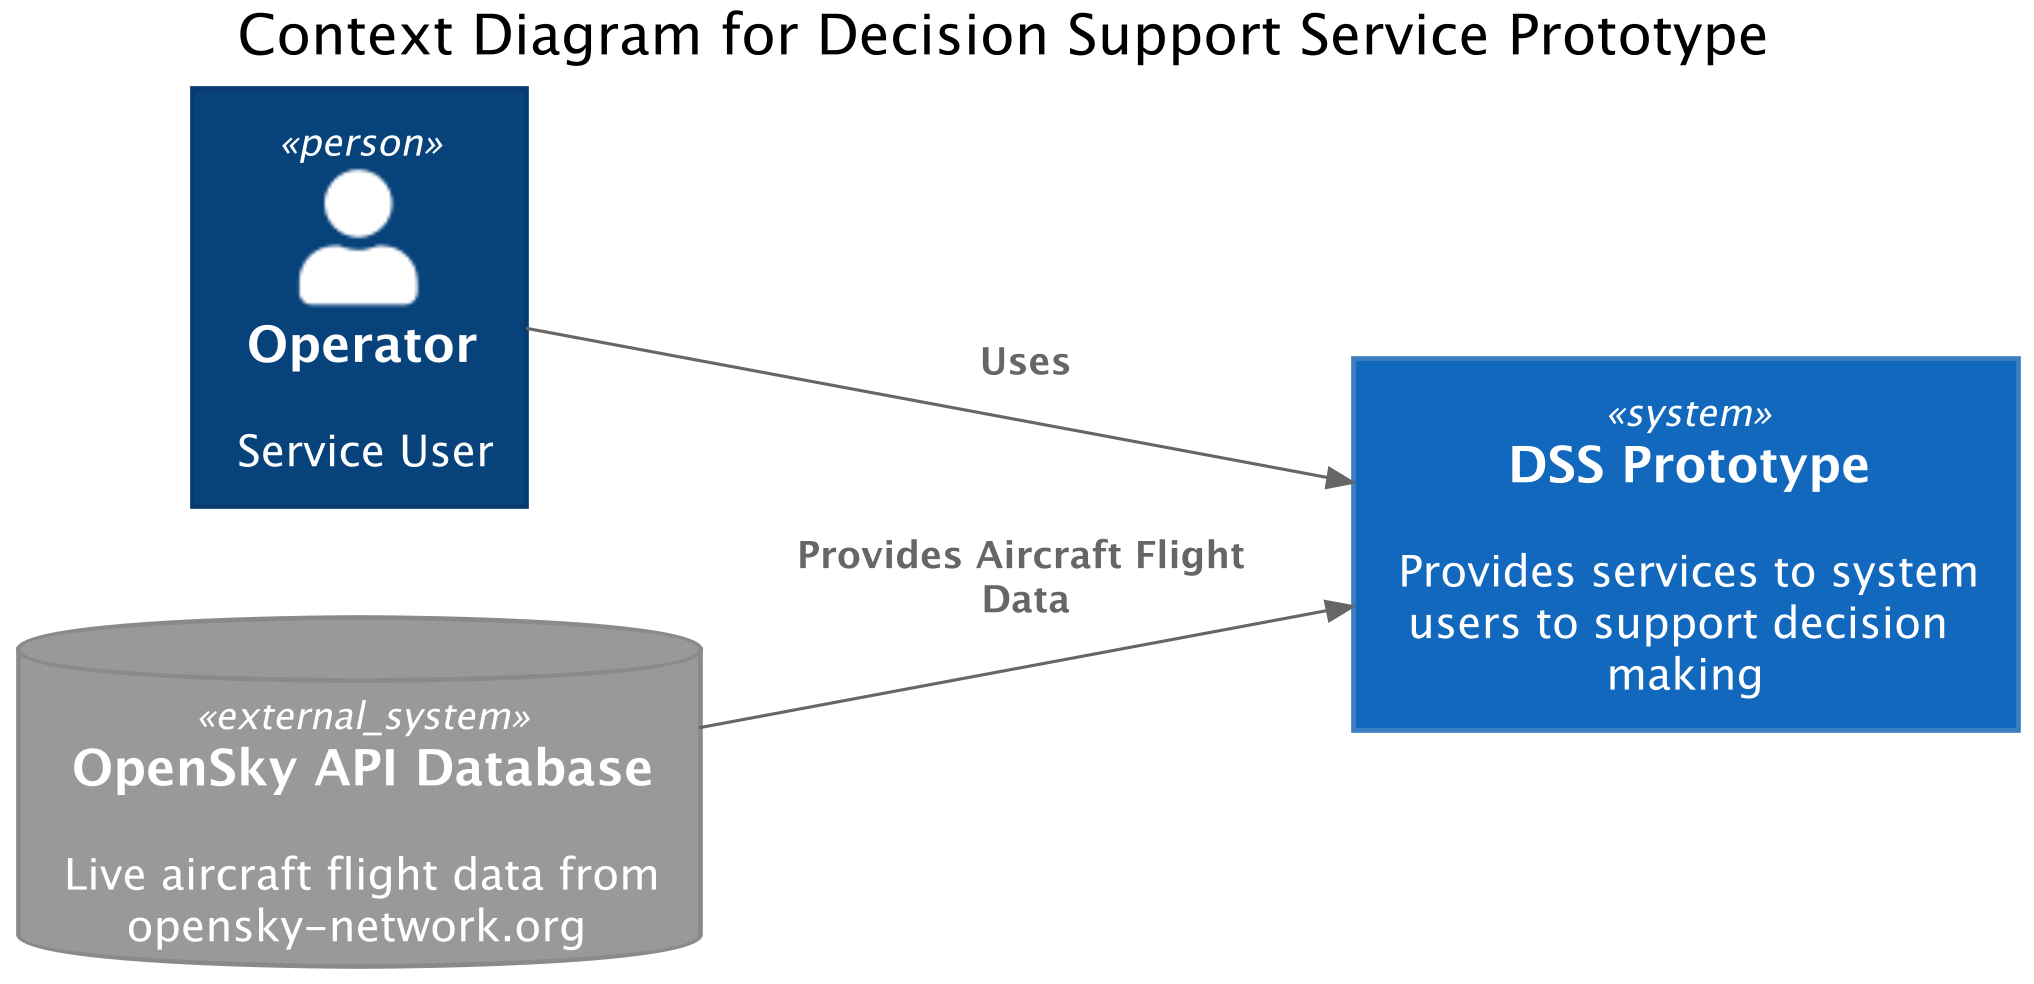

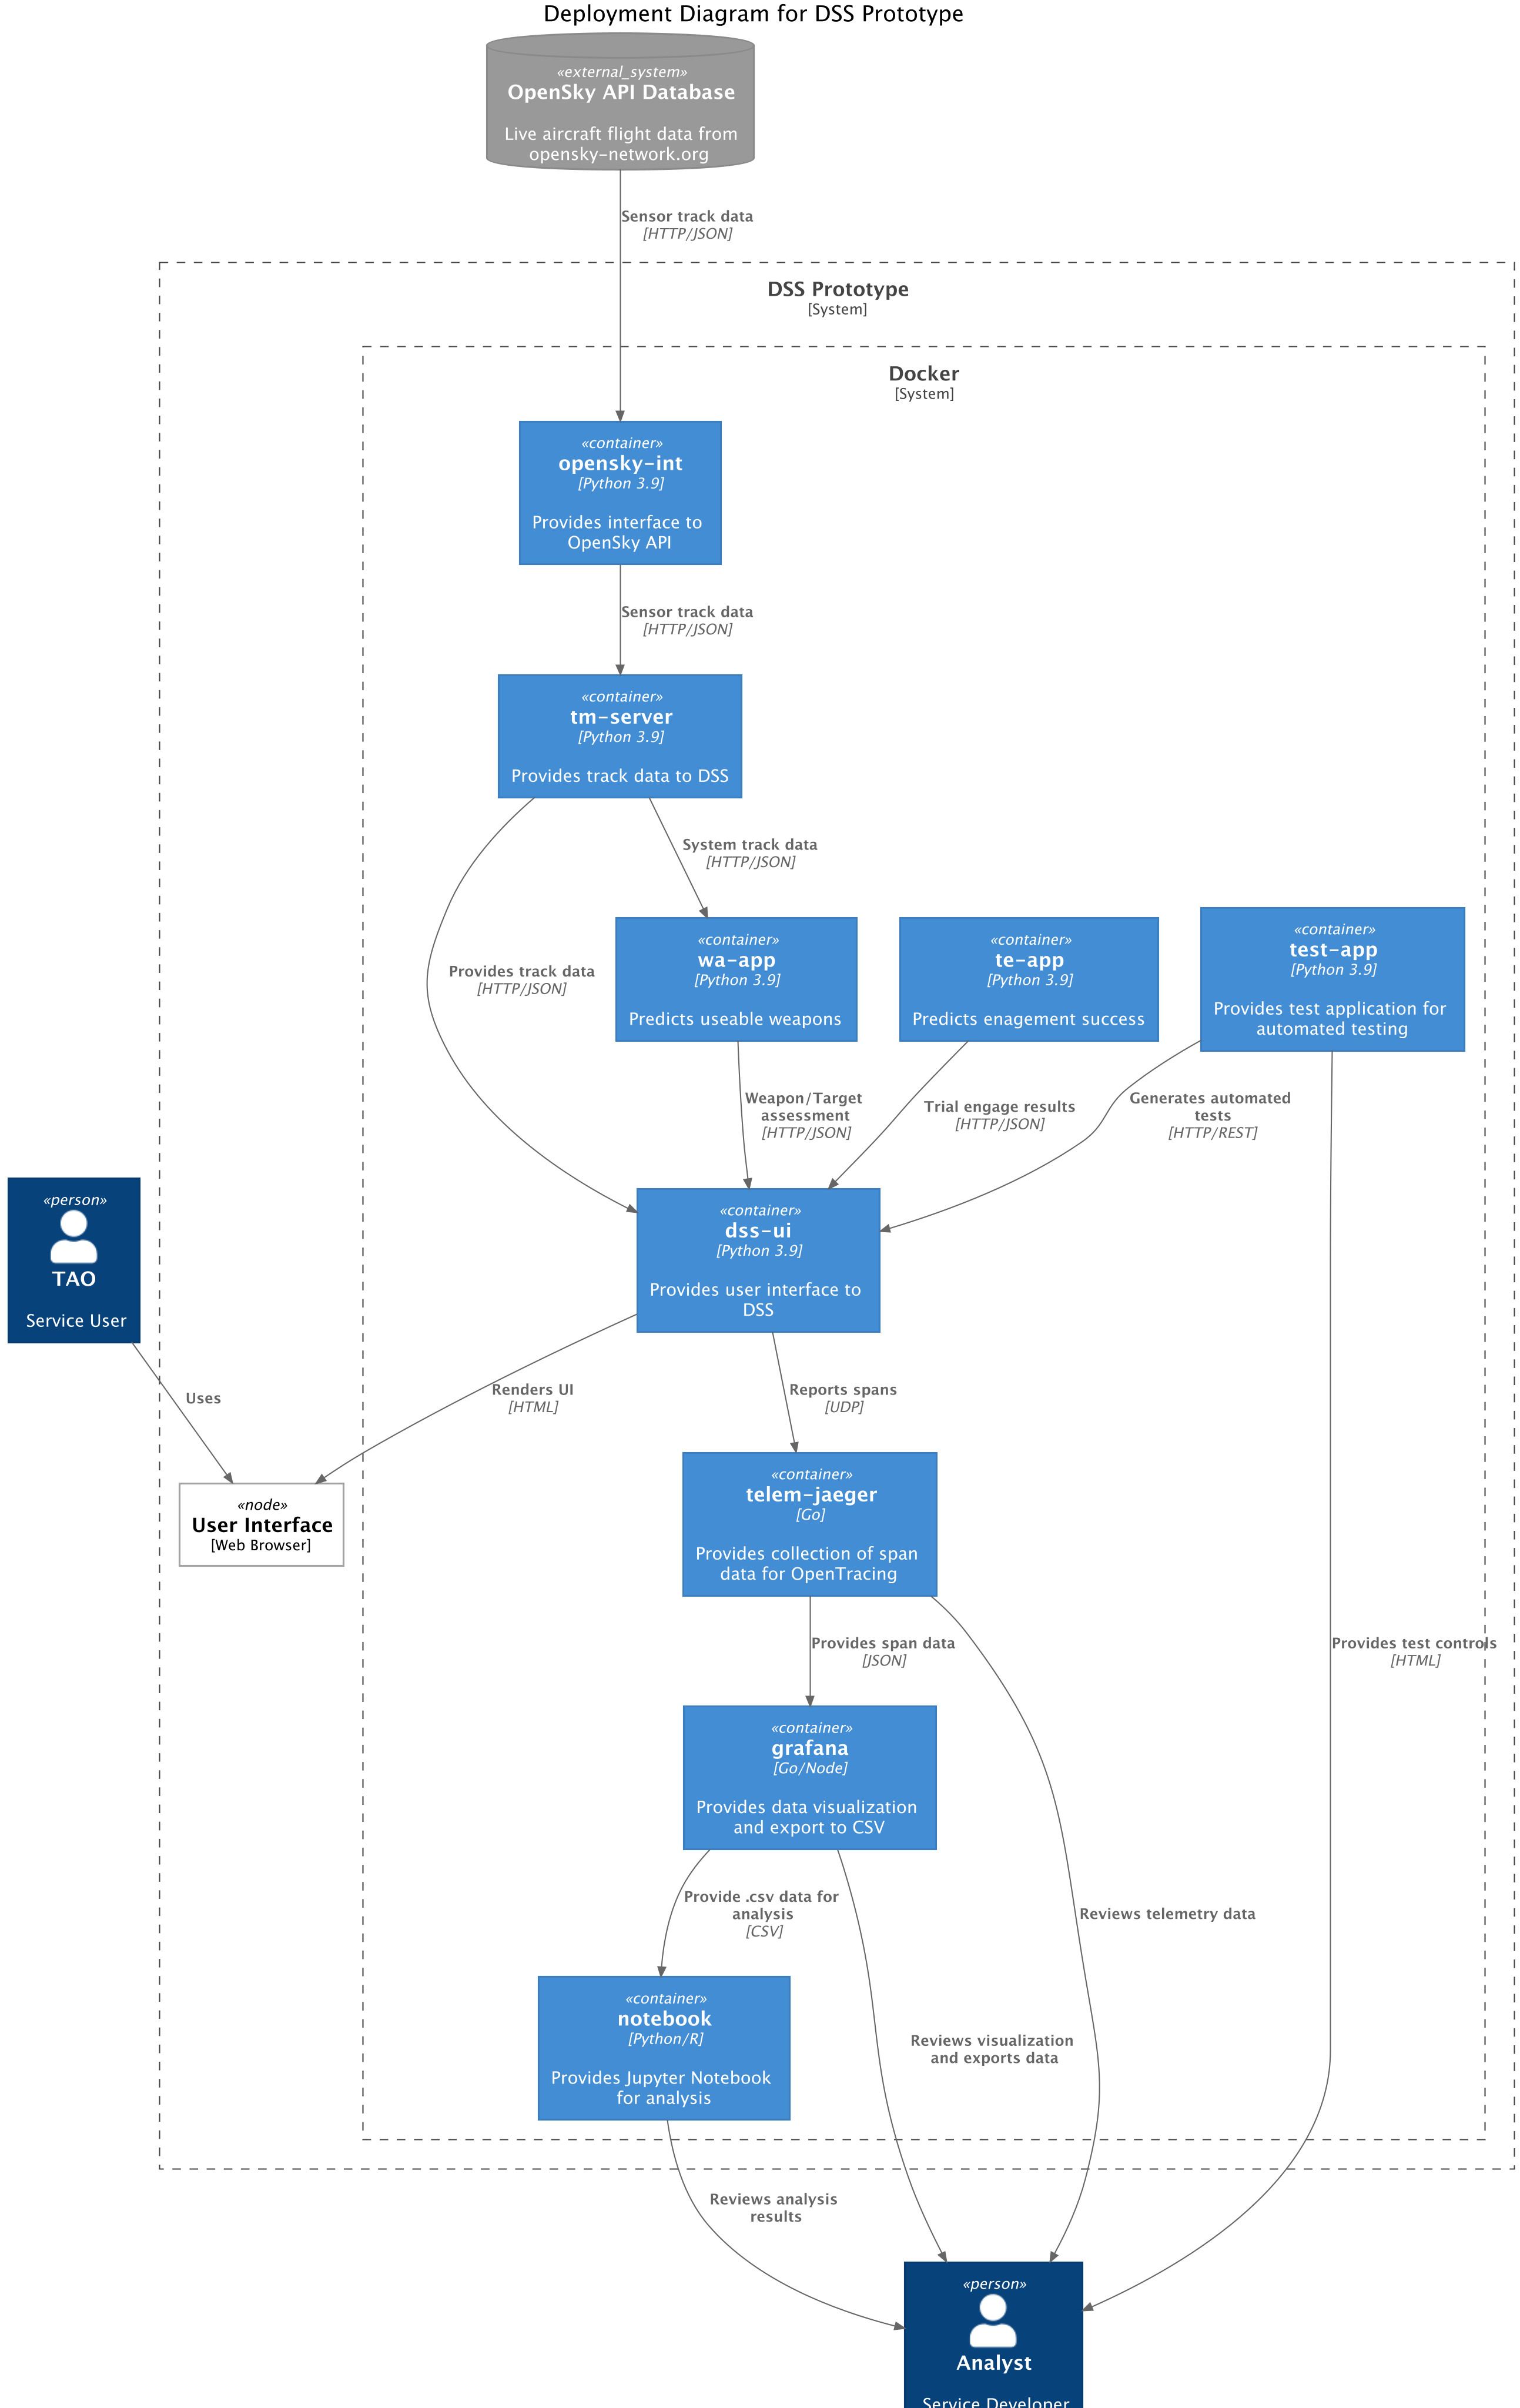

In [1]:
install.packages("stringr")                # Install packages and libraries in R
library("stringr")                       
# install.packages("dplyr")
# library("dplyr")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
setwd('/home/jovyan/work/data')

In [3]:
options(warn=-1)
spanData <- read.csv('DSS Span Data-data-2022-04-22 16_42_05.csv', header = TRUE)
attach(spanData)

# Exploratory Data Analysis #

In [4]:
head(spanData)

,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<chr>,<chr>
1,61493c5f11c88d744e8a03e84684349e,dss-prototype: /TE,2022-04-22 20:36:22.988,21.6 ms
2,ae848223690829c625d1b4dc57a678f0,dss-prototype: /tracks,2022-04-22 20:36:21.945,32.5 ms
3,102b6b2d6a5a4ddc3d850fd7f87240b5,dss-prototype: /WA,2022-04-22 20:36:20.893,36.7 ms
4,a077c98933a8e3537a6f5df54324f8a4,dss-prototype: /TE,2022-04-22 20:36:19.858,25.2 ms
5,b9d12af2efa9b7972335302368388569,dss-prototype: /tracks,2022-04-22 20:36:18.819,27.8 ms
6,3a5bebf3b57e37c8a30c3db1c948457e,dss-prototype: /WA,2022-04-22 20:36:17.756,44.0 ms


In [5]:
summary(spanData)

   Trace.ID          Trace.name         Start.time          Duration        
 Length:100         Length:100         Length:100         Length:100        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

In [6]:
# Convert character data into numeric metrics

spanMetrics <- spanData

for(i in 1:nrow(spanMetrics)) {       # for-loop over rows
    
    # Convert span duration
    
    char = spanMetrics[i,4]
    len = str_length(char)
    duration = str_sub(char,1,(len-3))
    units = str_sub(char,(len-1),len)
    duration = as.numeric(duration)
    
    # print(duration)
    # print(units)

    if(units == 'ms') {
        duration = duration / 1000              # Convert to ms
    } else if (units == 'µs') {
        duration = duration / 1000000           # Convert to µs
    } else if (units == ' s') {
        duration = duration
    } else {
        print ('Unable to find specified units')
        print (units)
    }
    spanMetrics[i,4] = duration
    
    # Convert time

    time = spanMetrics[i,3]
    epoch <- as.POSIXct(time)
    epoch_int <- as.integer(epoch)
    spanMetrics[i,3] = epoch_int
}

# Convert columns for char to numeric

spanMetrics$Duration = as.numeric(spanMetrics$Duration)
spanMetrics$Start.time = as.numeric(spanMetrics$Start.time)

head(spanMetrics)
tail(spanMetrics)
summary(spanMetrics)

,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
1,61493c5f11c88d744e8a03e84684349e,dss-prototype: /TE,1650659782,0.0216
2,ae848223690829c625d1b4dc57a678f0,dss-prototype: /tracks,1650659781,0.0325
3,102b6b2d6a5a4ddc3d850fd7f87240b5,dss-prototype: /WA,1650659780,0.0367
4,a077c98933a8e3537a6f5df54324f8a4,dss-prototype: /TE,1650659779,0.0252
5,b9d12af2efa9b7972335302368388569,dss-prototype: /tracks,1650659778,0.0278
6,3a5bebf3b57e37c8a30c3db1c948457e,dss-prototype: /WA,1650659777,0.0440


,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
95,500bec0ac13deb4402486d67c3de2cb2,dss-prototype: /TE,1650659679,0.0227
96,097e89a14bcbc6ac3dd042d261cc598e,dss-prototype: /tracks,1650659678,0.0149
97,44500d3f336093f0b24265c2edbd9863,dss-prototype: /WA,1650659677,0.0368
98,c434ee99757caf9804757bec6cca55b0,dss-prototype: /TE,1650659676,0.0427
99,3d1eb9366f41964ec4c08ca3f4f92c54,dss-prototype: /tracks,1650659675,0.0109
100,2b6b54a412d2a7e695a7cb116e91afb0,dss-prototype: /IAD,1650659674,0.7840


   Trace.ID          Trace.name          Start.time           Duration      
 Length:100         Length:100         Min.   :1.651e+09   Min.   :0.00966  
 Class :character   Class :character   1st Qu.:1.651e+09   1st Qu.:0.01755  
 Mode  :character   Mode  :character   Median :1.651e+09   Median :0.02925  
                                       Mean   :1.651e+09   Mean   :0.08648  
                                       3rd Qu.:1.651e+09   3rd Qu.:0.04035  
                                       Max.   :1.651e+09   Max.   :1.00000  

## Search for outliers

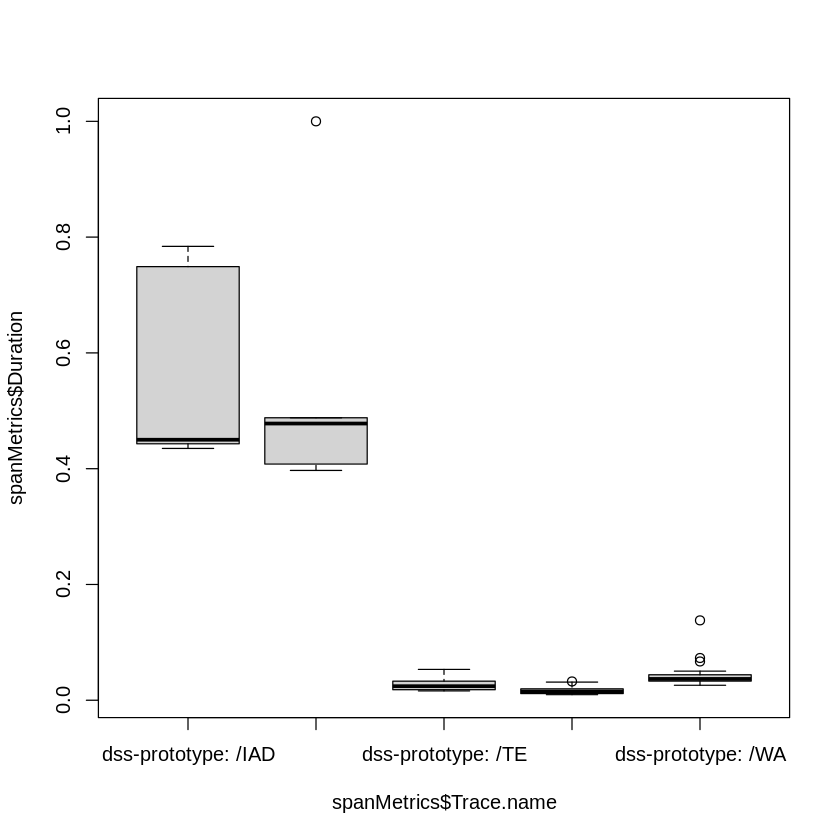

In [7]:
boxplot(spanMetrics$Duration~spanMetrics$Trace.name)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



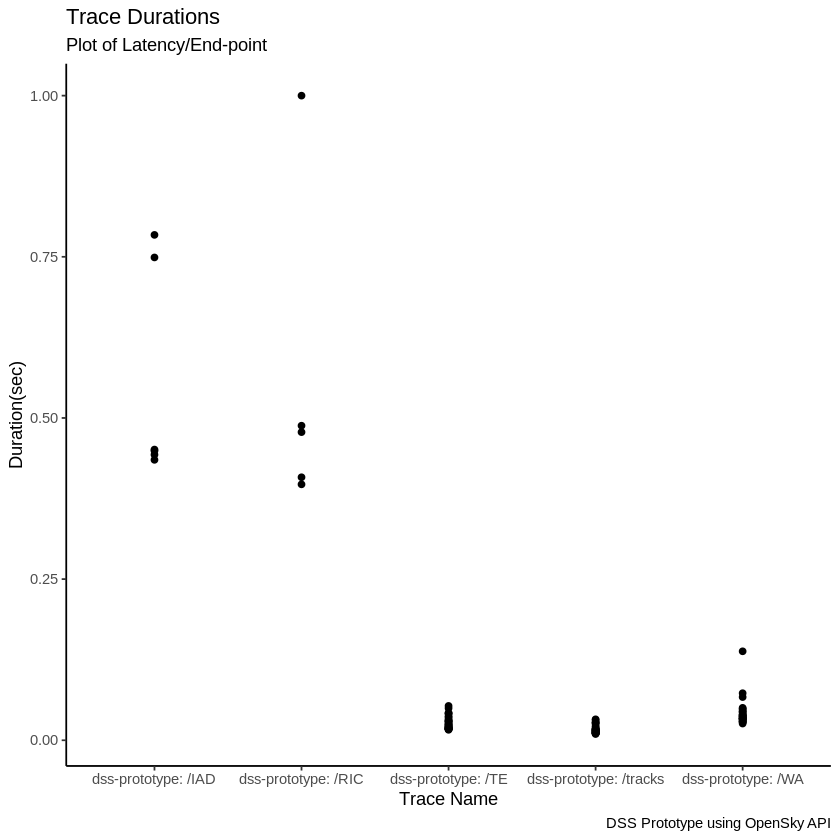

In [8]:
library(tidyverse)
theme_set(theme_classic())

# create a plot
# ggplot(spanMetrics, aes(Duration, Trace.name)) +
#   geom_point() +
#   geom_smooth() 

ggplot(spanMetrics, aes(Trace.name, Duration)) +
    geom_point() +
    geom_smooth() +
    labs(title = "Trace Durations",
              subtitle = "Plot of Latency/End-point",
              caption = "DSS Prototype using OpenSky API",
              x = "Trace Name", y = "Duration(sec)")

We want to separate the external metrics from internal to keep the accidental removal of external metrics as outliers.

In [9]:
# Use this to get the values of the statistical outliers in trk_update_data from R
outliers <- boxplot(spanMetrics$Duration, plot = FALSE)$out
outliers

cleanMetrics <- spanMetrics
cleanMetrics <- cleanMetrics[-which(cleanMetrics$Duration %in% outliers),]

[1] 0.451 1.000 0.443 0.488 0.138 0.749 0.478 0.449 0.408 0.435 0.397 0.784

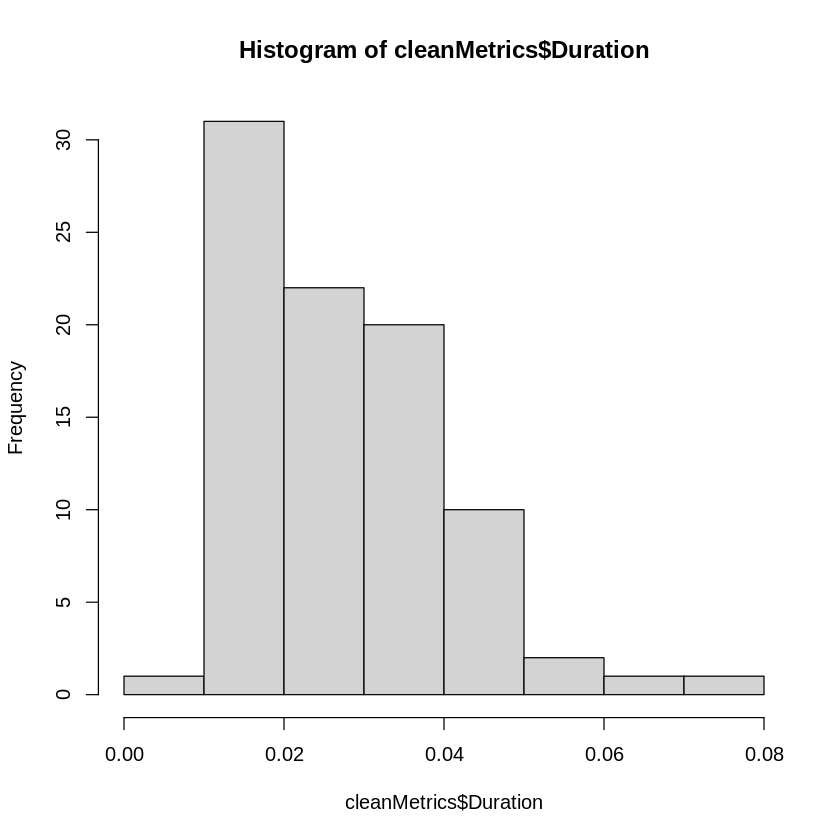

In [10]:
# par(mfrow=c(2,2))
hist(cleanMetrics$Duration)

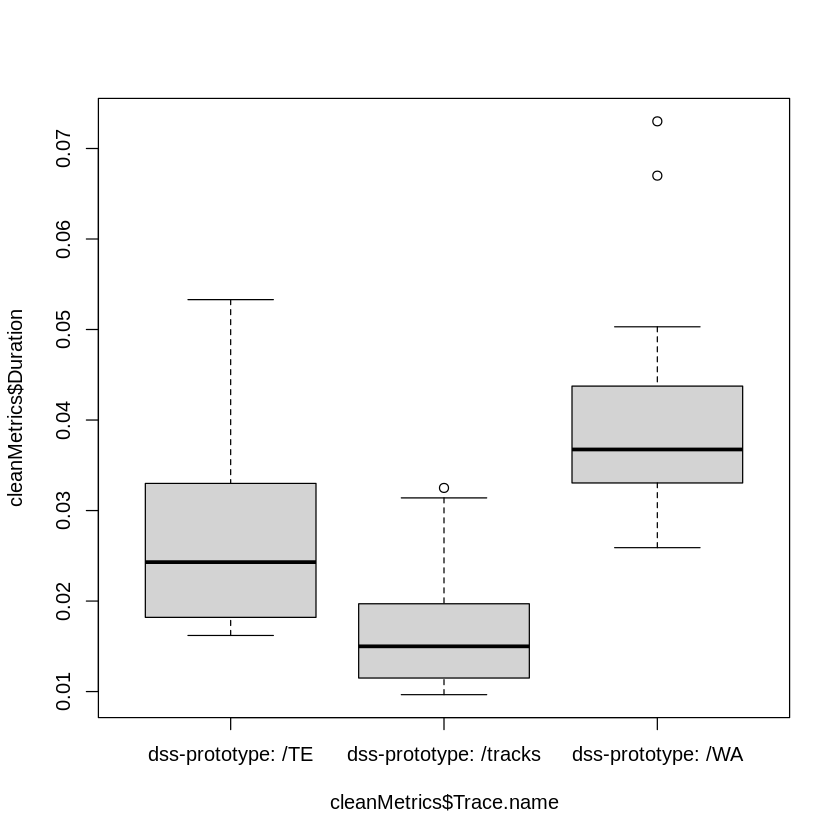

In [11]:
boxplot(cleanMetrics$Duration~cleanMetrics$Trace.name)

,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
2,ae848223690829c625d1b4dc57a678f0,dss-prototype: /tracks,1650659781,0.0325
5,b9d12af2efa9b7972335302368388569,dss-prototype: /tracks,1650659778,0.0278
8,8c2f32403811deb48fb033031d1ee5d5,dss-prototype: /tracks,1650659775,0.0141
11,301c201176fb8bf7b1423aeced14306c,dss-prototype: /tracks,1650659772,0.0173
14,43a1e3e8231185a1ef4cff6922c52935,dss-prototype: /tracks,1650659769,0.0115
19,1cc75153db1e3551ee5b8461a67059f8,dss-prototype: /tracks,1650659762,0.0114


,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
1,61493c5f11c88d744e8a03e84684349e,dss-prototype: /TE,1650659782,0.0216
4,a077c98933a8e3537a6f5df54324f8a4,dss-prototype: /TE,1650659779,0.0252
7,08bba9377693ae3d01d10565b0f6aca1,dss-prototype: /TE,1650659776,0.0178
10,fffe8e9ce55bf7a01ad211940024c549,dss-prototype: /TE,1650659773,0.0497
13,af80e4b89b29d011ad6c4fc73d150247,dss-prototype: /TE,1650659770,0.0533
18,034112ca46fc85f3c372bd073eb2d61e,dss-prototype: /TE,1650659763,0.0291


,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
3,102b6b2d6a5a4ddc3d850fd7f87240b5,dss-prototype: /WA,1650659780,0.0367
6,3a5bebf3b57e37c8a30c3db1c948457e,dss-prototype: /WA,1650659777,0.0440
9,56be5ec31fe6efcf8fbce034fb4382f7,dss-prototype: /WA,1650659774,0.0670
12,8fab8690048440981dbe2299cacd60c0,dss-prototype: /WA,1650659771,0.0281
17,4b9e9e9c2db27a756fb467c2462ba52d,dss-prototype: /WA,1650659764,0.0401
20,1c46ba8965e4661e1239744b44c593c2,dss-prototype: /WA,1650659761,0.0332


,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
2,ae848223690829c625d1b4dc57a678f0,dss-prototype: /tracks,1650659781,0.0325
5,b9d12af2efa9b7972335302368388569,dss-prototype: /tracks,1650659778,0.0278
8,8c2f32403811deb48fb033031d1ee5d5,dss-prototype: /tracks,1650659775,0.0141
11,301c201176fb8bf7b1423aeced14306c,dss-prototype: /tracks,1650659772,0.0173
14,43a1e3e8231185a1ef4cff6922c52935,dss-prototype: /tracks,1650659769,0.0115
19,1cc75153db1e3551ee5b8461a67059f8,dss-prototype: /tracks,1650659762,0.0114


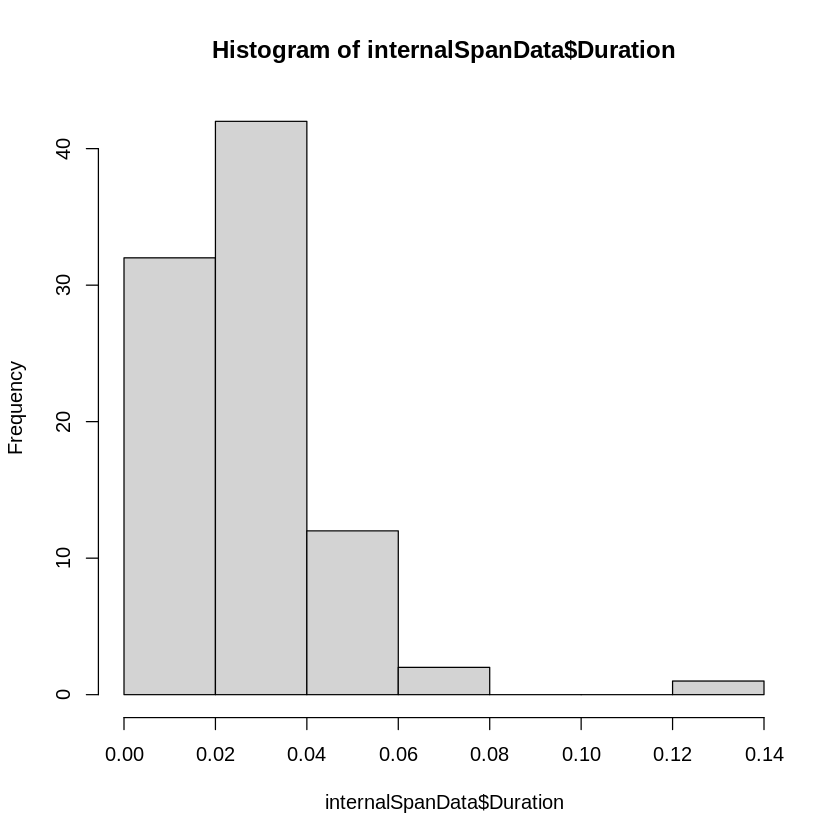

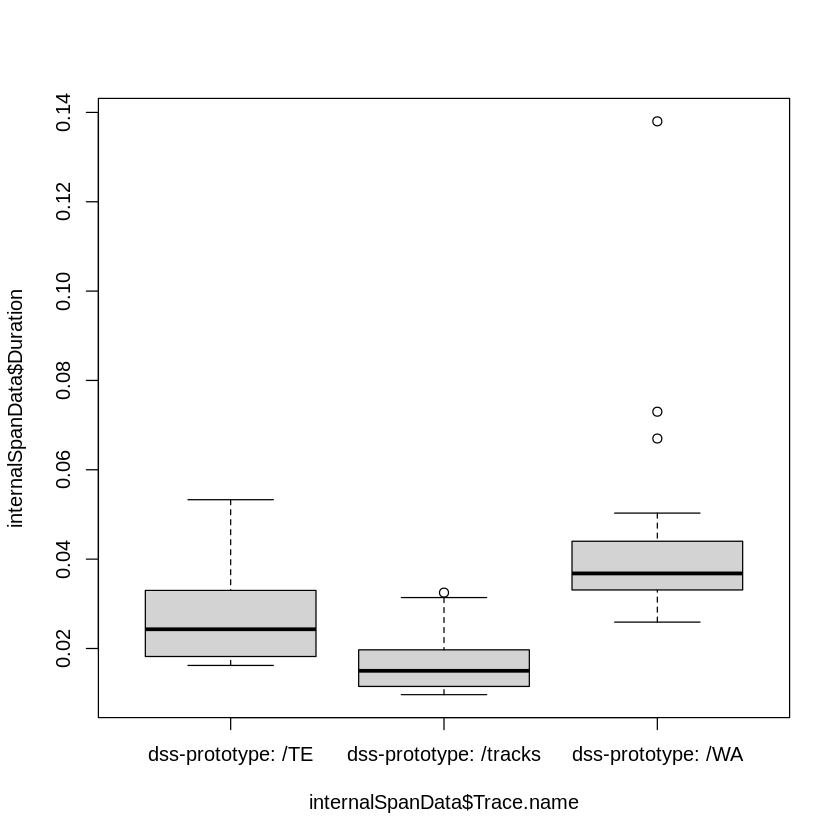

In [12]:
tracksSpanData = subset(spanMetrics, Trace.name == "dss-prototype: /tracks")
TE_SpanData = subset(spanMetrics, Trace.name == "dss-prototype: /TE")
WA_SpanData = subset(spanMetrics, Trace.name == "dss-prototype: /WA")

internalSpanData <- rbind(tracksSpanData, TE_SpanData, WA_SpanData)
dssSpanData <- rbind(TE_SpanData, WA_SpanData)

head(tracksSpanData)
head(TE_SpanData)
head(WA_SpanData)
head(internalSpanData)

#par(mfrow=c(2,1))
hist(internalSpanData$Duration)
boxplot(internalSpanData$Duration~internalSpanData$Trace.name)

Remove internal span outliers.

[1] 0.067 0.138 0.073

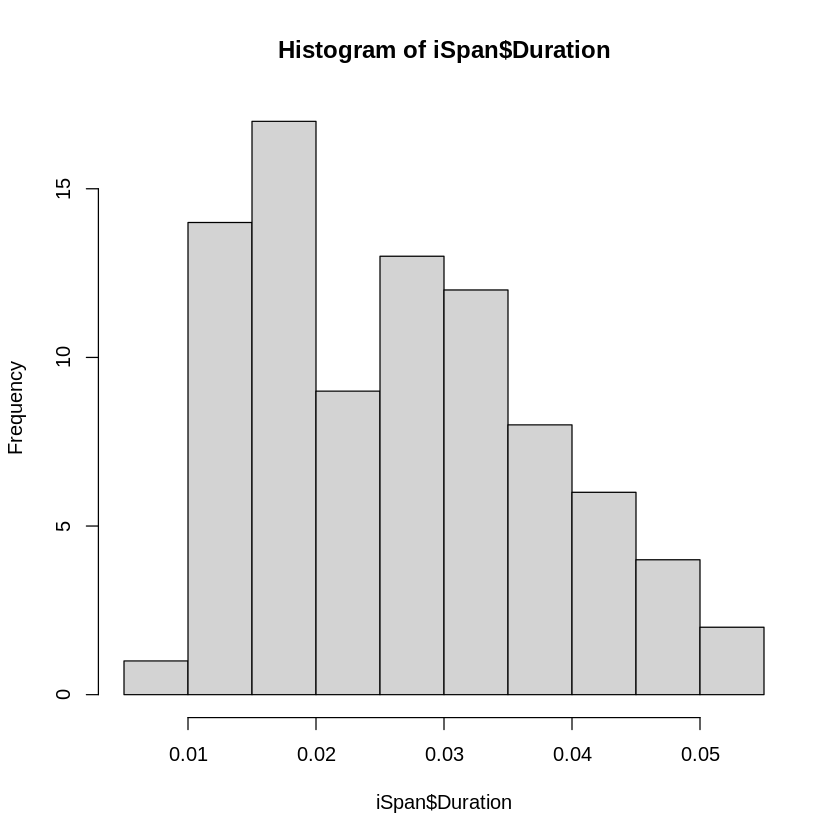

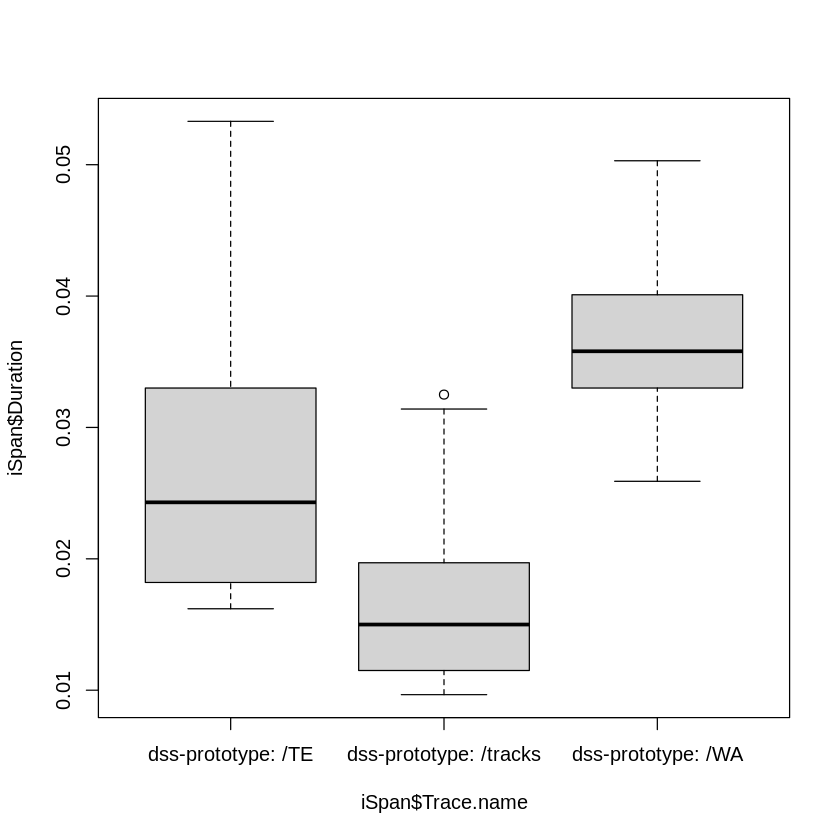

In [13]:
outliers <- boxplot(internalSpanData$Duration, plot = FALSE)$out
outliers

iSpan <- internalSpanData
iSpan <- iSpan[-which(iSpan$Duration %in% outliers),]
hist(iSpan$Duration)
boxplot(iSpan$Duration~iSpan$Trace.name)

,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
16,71d85e2851ef54a469c57065b50d54fe,dss-prototype: /RIC,1650659765,1.000
33,61fa585ace804b6de562cb22d58de016,dss-prototype: /RIC,1650659747,0.488
50,5ad611583579fa2a8dcb9e100ddef2f7,dss-prototype: /RIC,1650659728,0.478
67,aa5b6526bd4e482a9f9fa99c7dc1fbb2,dss-prototype: /RIC,1650659709,0.408
84,7581e0cb6042dee68f8cfe444524bd24,dss-prototype: /RIC,1650659691,0.397


,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
15,a88d9ff1af95ca8cfba2c46cb988dda1,dss-prototype: /IAD,1650659767,0.451
32,b93462cdfdcfacef9900eca5a394cba6,dss-prototype: /IAD,1650659748,0.443
49,b285d225fc15bf300c8422193c21ceb7,dss-prototype: /IAD,1650659729,0.749
66,2108b615081990c7cd19f8483a21b22c,dss-prototype: /IAD,1650659711,0.449
83,705cffe8483737f6aff9189f5b39521a,dss-prototype: /IAD,1650659692,0.435
100,2b6b54a412d2a7e695a7cb116e91afb0,dss-prototype: /IAD,1650659674,0.784


,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
16,71d85e2851ef54a469c57065b50d54fe,dss-prototype: /RIC,1650659765,1.000
33,61fa585ace804b6de562cb22d58de016,dss-prototype: /RIC,1650659747,0.488
50,5ad611583579fa2a8dcb9e100ddef2f7,dss-prototype: /RIC,1650659728,0.478
67,aa5b6526bd4e482a9f9fa99c7dc1fbb2,dss-prototype: /RIC,1650659709,0.408
84,7581e0cb6042dee68f8cfe444524bd24,dss-prototype: /RIC,1650659691,0.397
15,a88d9ff1af95ca8cfba2c46cb988dda1,dss-prototype: /IAD,1650659767,0.451


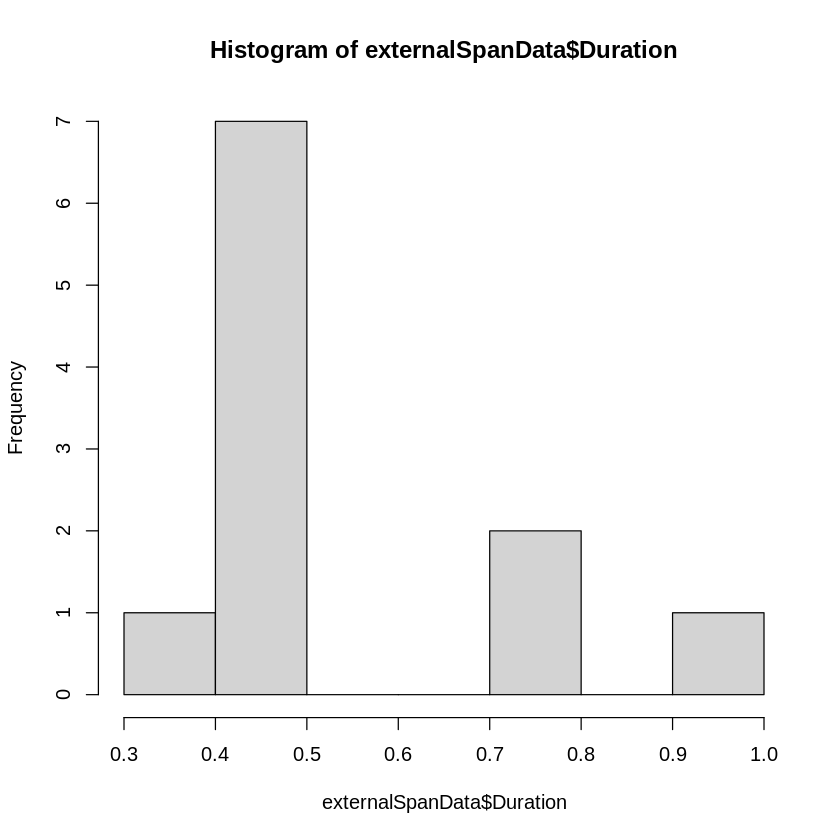

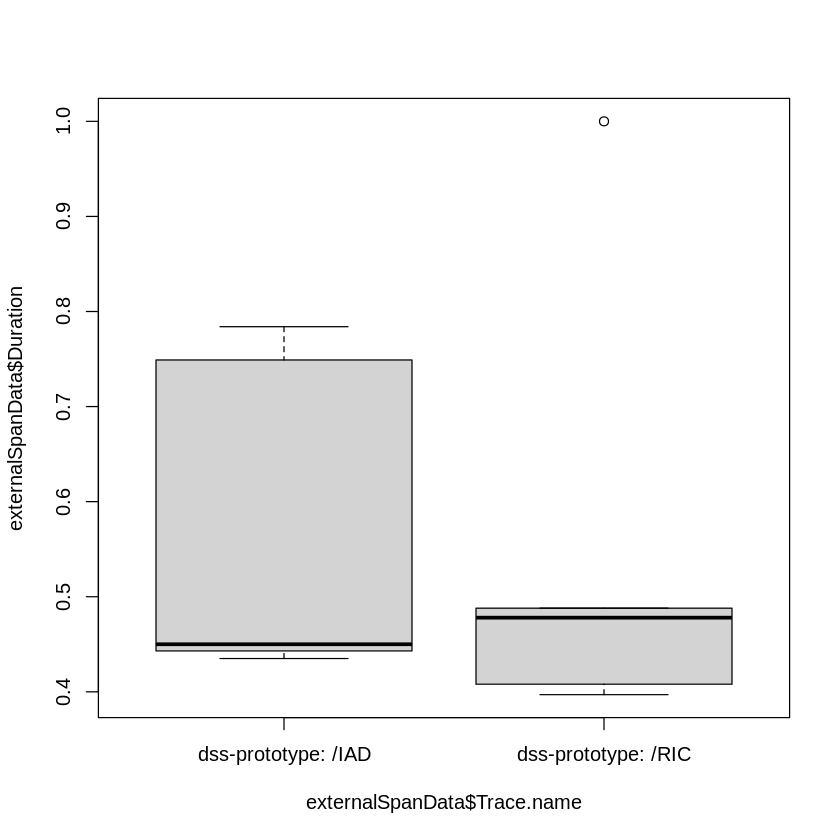

In [14]:
RIC_SpanData = subset(spanMetrics, Trace.name == "dss-prototype: /RIC")
IAD_SpanData = subset(spanMetrics, Trace.name == "dss-prototype: /IAD")

externalSpanData <- rbind(RIC_SpanData, IAD_SpanData)

head(RIC_SpanData)
head(IAD_SpanData)
head(externalSpanData)
hist(externalSpanData$Duration)
boxplot(externalSpanData$Duration~externalSpanData$Trace.name)

[1] 1

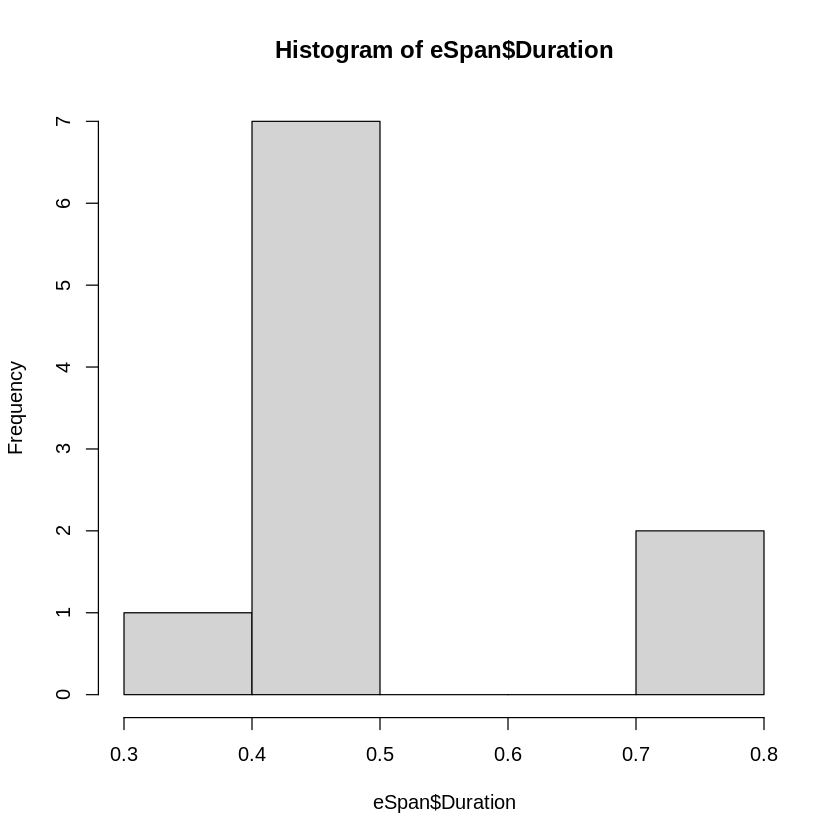

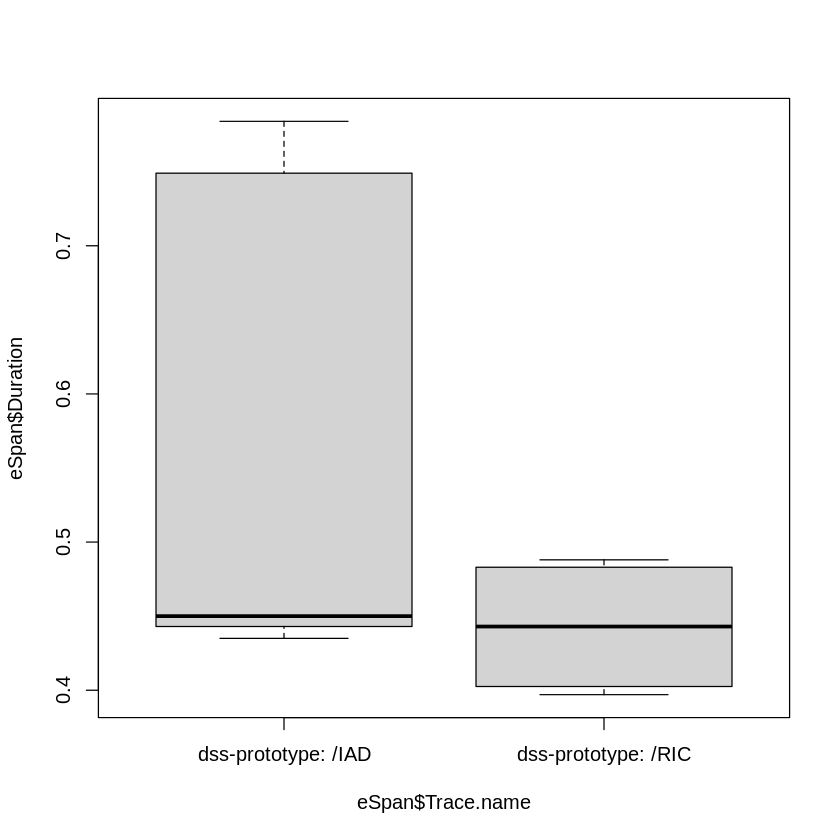

In [15]:
outliers <- boxplot(externalSpanData$Duration, plot = FALSE)$out
outliers

eSpan <- externalSpanData
eSpan <- eSpan[-which(eSpan$Duration %in% outliers),]
hist(eSpan$Duration)
boxplot(eSpan$Duration~eSpan$Trace.name)

# Transformation

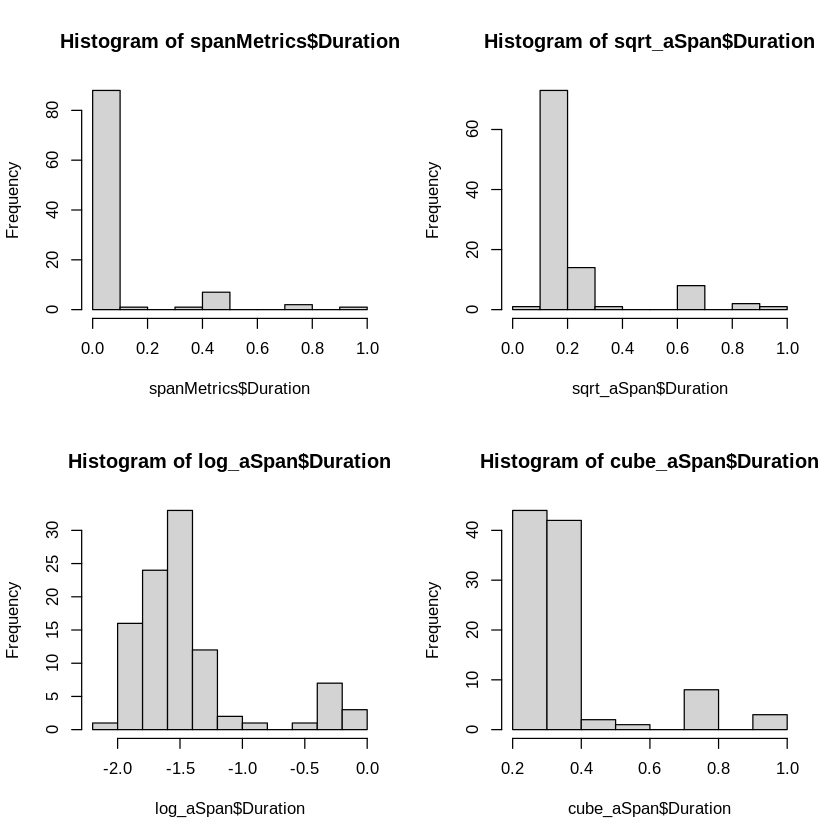

In [16]:
sqrt_aSpan <- spanMetrics
sqrt_aSpan$Duration=sqrt(sqrt_aSpan$Duration)
log_aSpan <- spanMetrics
log_aSpan$Duration=log10(log_aSpan$Duration)
cube_aSpan <- spanMetrics
cube_aSpan$Duration=cube_aSpan$Duration^(1/3)

par(mfrow=c(2,2))
hist(spanMetrics$Duration)
hist(sqrt_aSpan$Duration)
hist(log_aSpan$Duration)
hist(cube_aSpan$Duration)

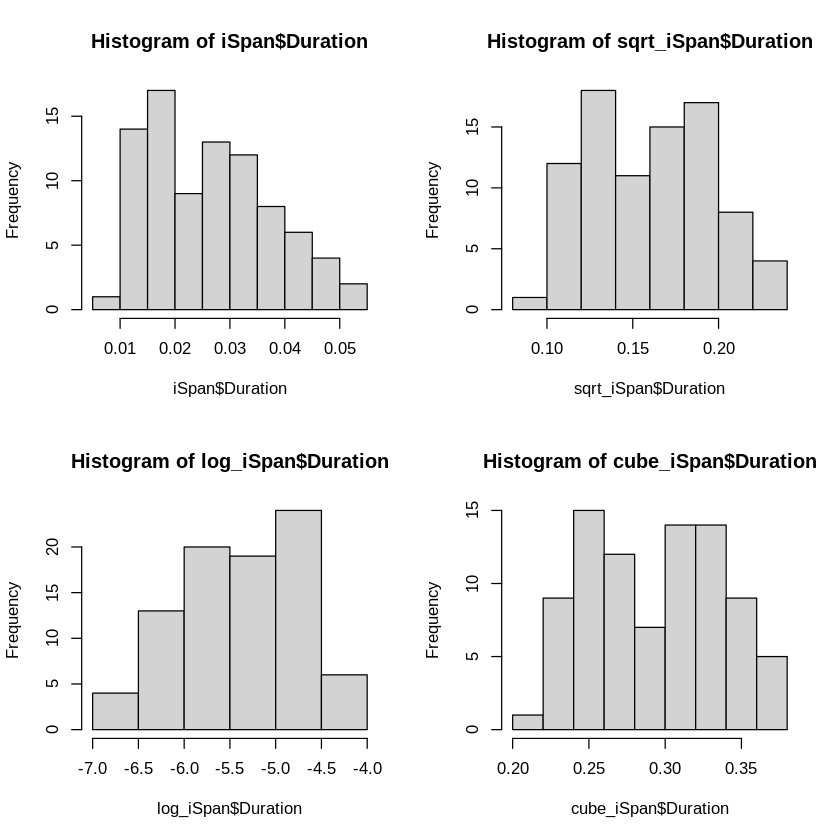

In [17]:
sqrt_iSpan <- iSpan
sqrt_iSpan$Duration=sqrt(sqrt_iSpan$Duration)
log_iSpan <- iSpan
log_iSpan$Duration=log2(log_iSpan$Duration)
cube_iSpan <- iSpan
cube_iSpan$Duration=cube_iSpan$Duration^(1/3)

par(mfrow=c(2,2))
hist(iSpan$Duration)
hist(sqrt_iSpan$Duration)
hist(log_iSpan$Duration)
hist(cube_iSpan$Duration)

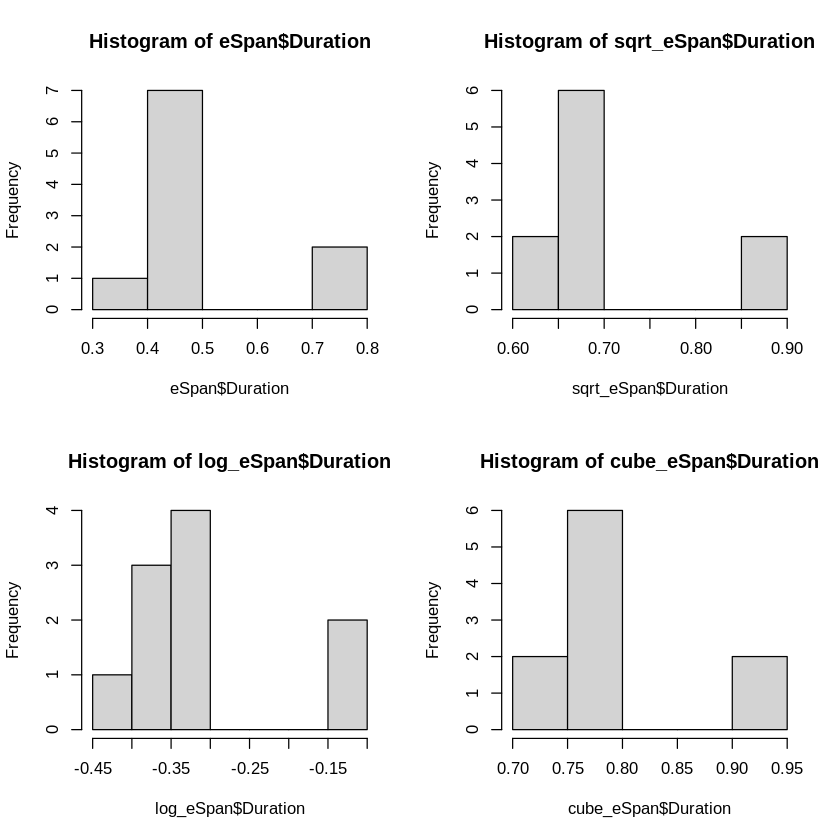

In [18]:
sqrt_eSpan <- eSpan
sqrt_eSpan$Duration=sqrt(sqrt_eSpan$Duration)
log_eSpan <- eSpan
log_eSpan$Duration=log10(log_eSpan$Duration)
cube_eSpan <- eSpan
cube_eSpan$Duration=cube_eSpan$Duration^(1/3)

par(mfrow=c(2,2))
hist(eSpan$Duration)
hist(sqrt_eSpan$Duration)
hist(log_eSpan$Duration)
hist(cube_eSpan$Duration)

## Box-Cox Transformation

Box and Cox (1964) developed a family of transformations designed to reduce nonnormality of the errors in a linear model. Applying this transform often reduces non-linearity as well, and heteroscedascity.

The idea is to transform the response variable $Y$ to a replacement response variable $Y_i^{(\lambda)}$, leaving the right-hand side of the regression model unchanged, so that the regression residuals become normally-distributed. Note that the regression coefficients will also change, because the response variable has changed; therefore, the regression coefficients must be interpreted with respect to the transformed variable. Also, any predictions made with the model have to be back-transformed, to be interpreted in the original units.

The standard (simple) Box-Cox transform is:

$$
    Y_i^{(\lambda)}=
\begin{cases}
{\frac {Y_i^\lambda - 1} \lambda},  & {(\lambda \neq 0)} \\
log(Y_i), & {(\lambda = 0)}
\end{cases}
$$

Box, G. E. P., & Cox, D. R. (1964). An Analysis of Transformations. Journal of the Royal Statistical Society, Series B (Metholodogical), 26(2), 211-252. 

http://www.css.cornell.edu/faculty/dgr2/_static/files/R_html/Transformations.html

In [19]:
library(MASS)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




Attempting to transform the entire data-set using Box-Cox Transformation. Note that the outliers had to be removed. 

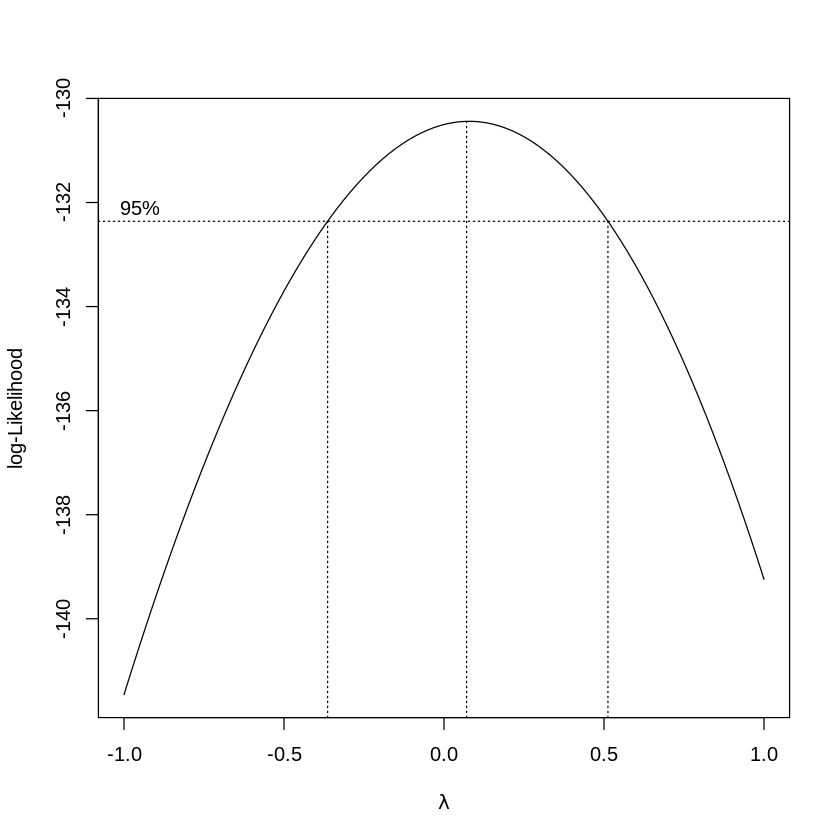

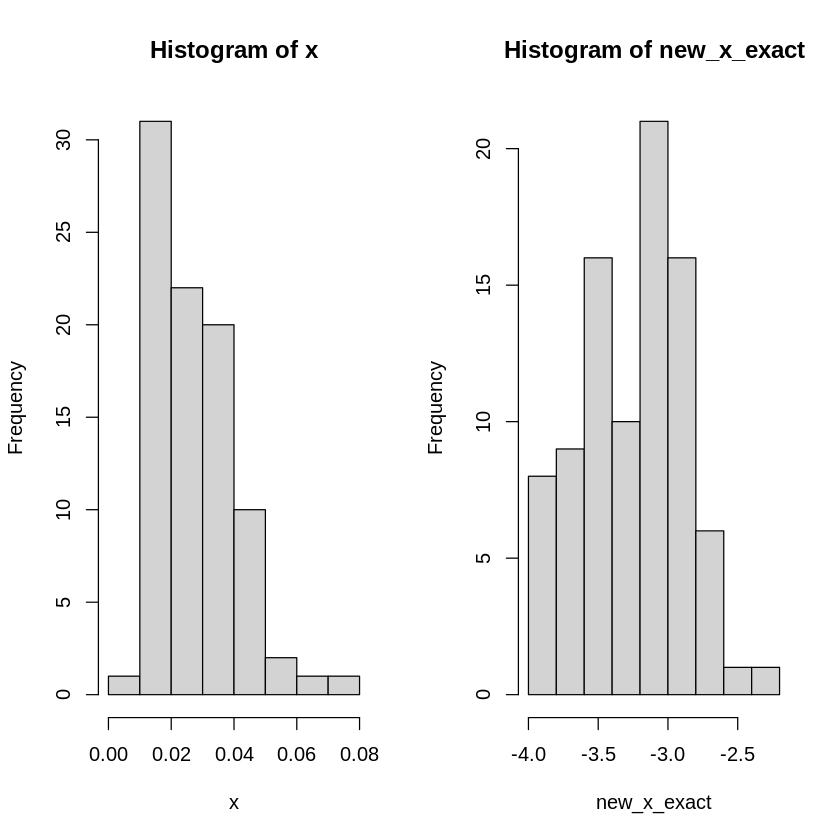

In [20]:
x <- cleanMetrics$Duration
bc = boxcox(lm(x ~ 1), seq(-1,1,.1))
#bc = boxcox(lm(x ~ 1))
lambda <- bc$x[which.max(bc$y)]
new_x_exact <- (x ^ lambda - 1) / lambda

par(mfrow=c(1,2))
hist(x)
hist(new_x_exact)

In [21]:
shapiro.test(new_x_exact)


	Shapiro-Wilk normality test

data:  new_x_exact
W = 0.97667, p-value = 0.1131


It seems that all of the external Spans are being removed as outliers. Let separate internal and external spans.

Just transforming internal Spans.

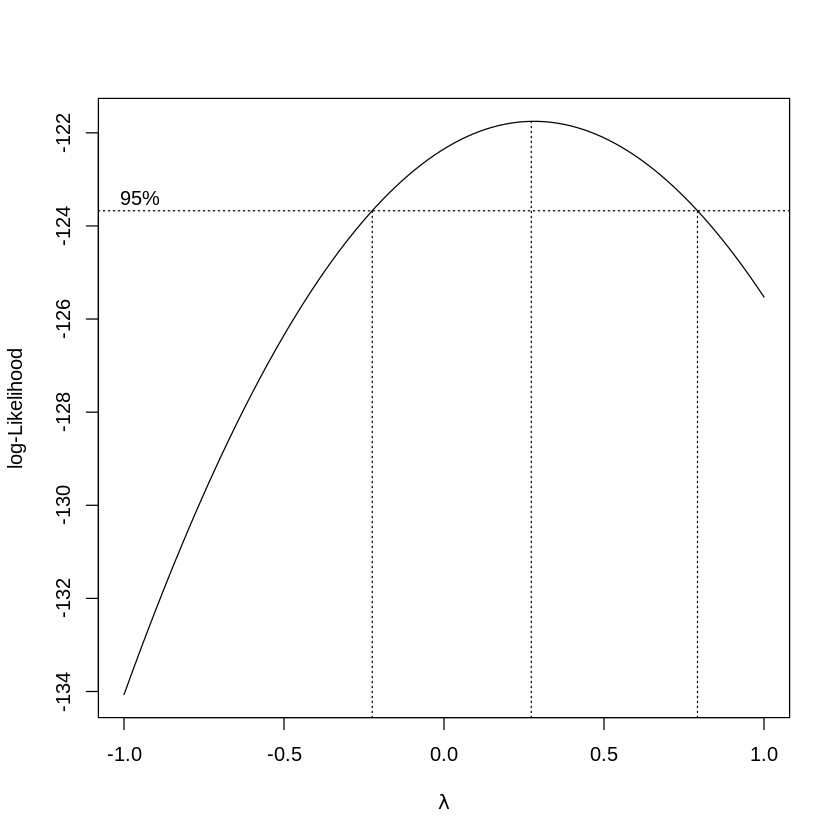

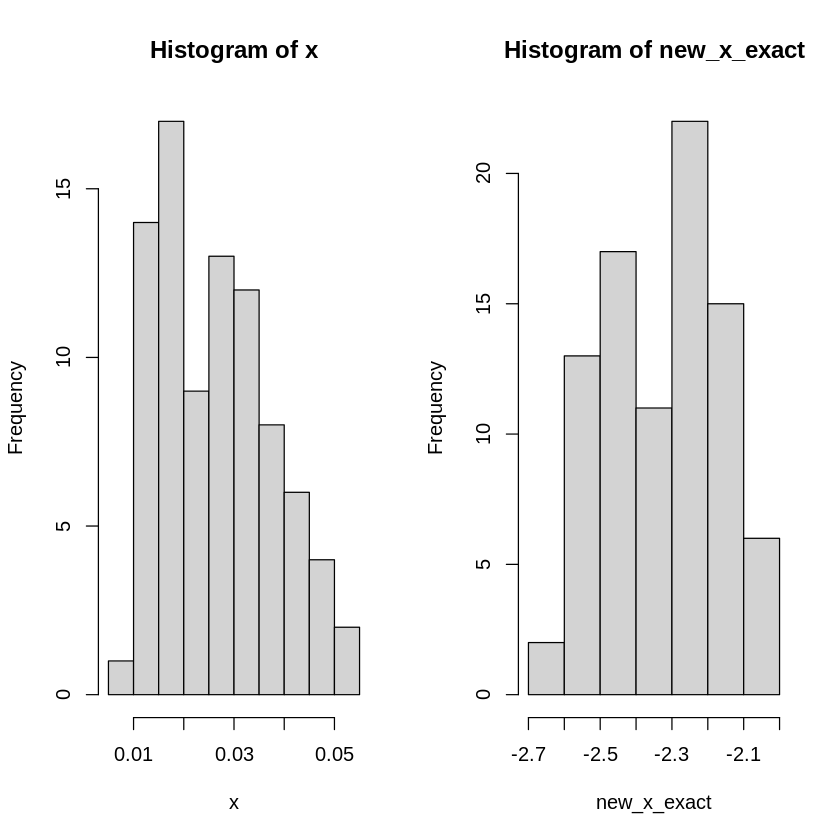

In [22]:
x <- iSpan$Duration
bc = boxcox(lm(x ~ 1), seq(-1,1,.1))
#bc = boxcox(lm(x ~ 1))
lambda <- bc$x[which.max(bc$y)]
new_x_exact <- (x ^ lambda - 1) / lambda

par(mfrow=c(1,2))
hist(x)
hist(new_x_exact)

In [23]:
shapiro.test(new_x_exact)


	Shapiro-Wilk normality test

data:  new_x_exact
W = 0.96569, p-value = 0.02195


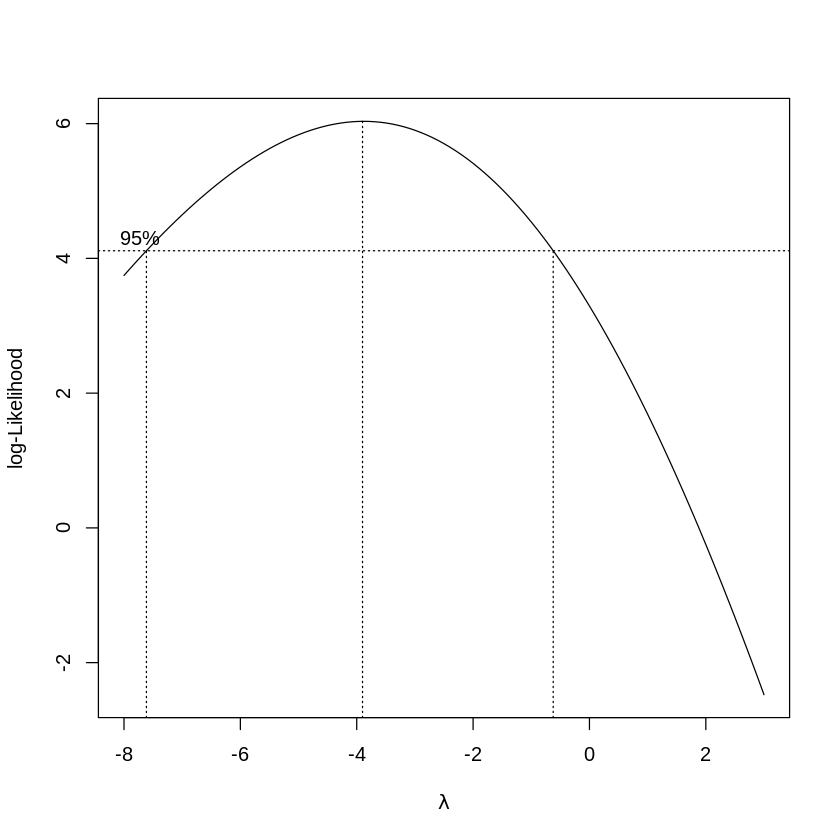

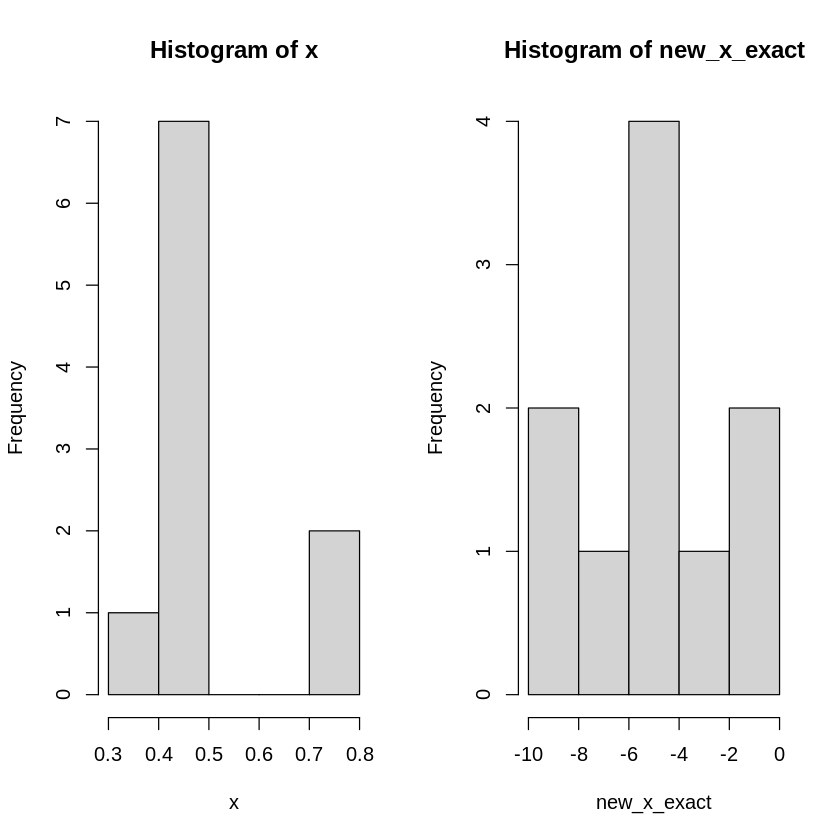

In [24]:
x <- eSpan$Duration
bc = boxcox(lm(x ~ 1), seq(-8,3,.1))
# bc = boxcox(lm(x ~ 1))
lambda <- bc$x[which.max(bc$y)]
new_x_exact <- (x ^ lambda - 1) / lambda

par(mfrow=c(1,2))
hist(x)
hist(new_x_exact)

In [25]:
shapiro.test(new_x_exact)


	Shapiro-Wilk normality test

data:  new_x_exact
W = 0.92934, p-value = 0.4414


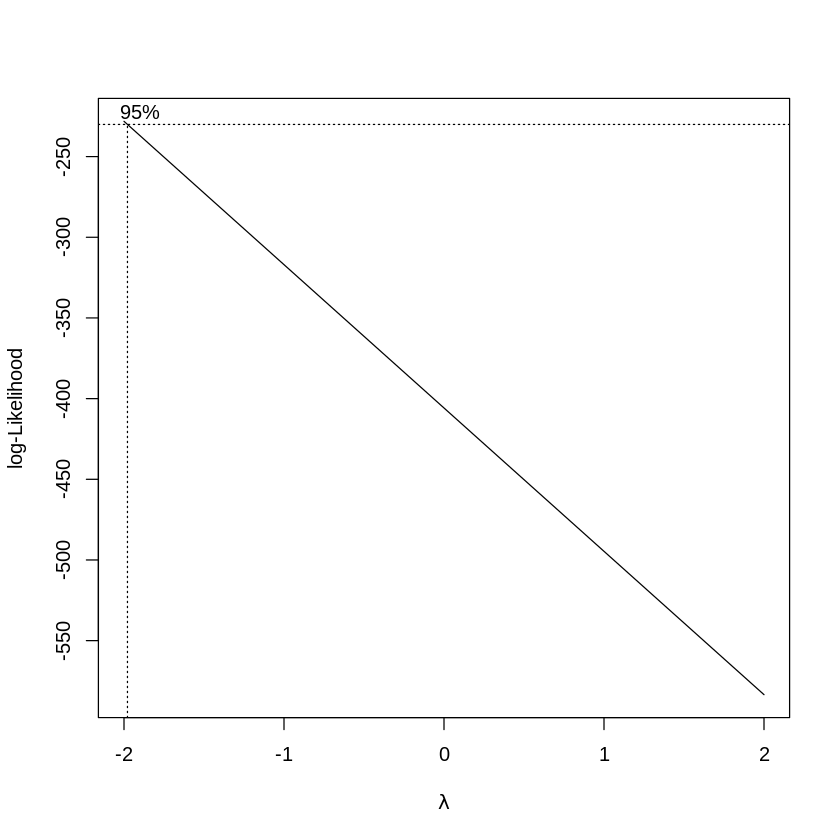


Call:
lm(formula = Duration ~ Trace.name, data = spanMetrics)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.15720 -0.00915 -0.00317  0.00296  0.44580 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.551833   0.026853  20.551   <2e-16 ***
Trace.namedss-prototype: /RIC     0.002367   0.039829   0.059    0.953    
Trace.namedss-prototype: /TE     -0.524497   0.029415 -17.831   <2e-16 ***
Trace.namedss-prototype: /tracks -0.534725   0.029415 -18.178   <2e-16 ***
Trace.namedss-prototype: /WA     -0.509326   0.029500 -17.265   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06577 on 95 degrees of freedom
Multiple R-squared:  0.8678,	Adjusted R-squared:  0.8623 
F-statistic: 155.9 on 4 and 95 DF,  p-value: < 2.2e-16


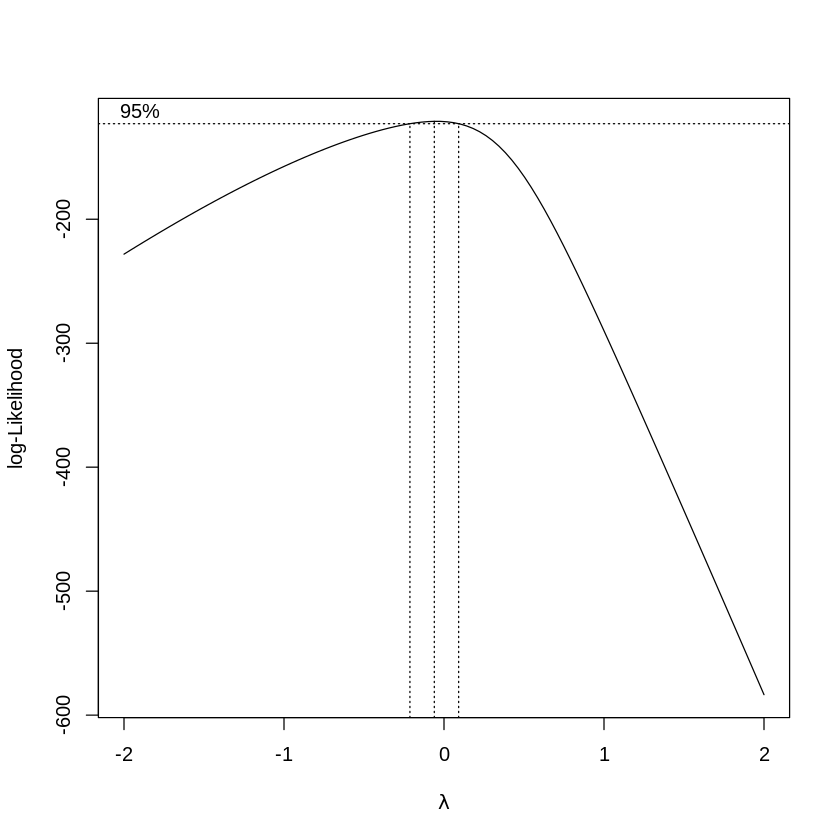

In [40]:
library(MASS)

model <- lm(Duration ~ Trace.name, data=spanMetrics)
bc <- boxcox(spanMetrics$Duration ~ spanMetrics$Trace.name, lambda=c(-2, 2))
bc <- boxcox(spanMetrics$Duration ~ spanMetrics$Trace.name)

summary(model)

In [27]:

# Exact lambda
(lambda <- iSpan$Trace.name[which.max(iSpan$Duration)])

lambda

# new_model <- lm(((iSpan$Duration ^ lambda - 1) / lambda) ~ iSpan$Trace.name)
# summary(new_model)

[1] "dss-prototype: /TE"

[1] "dss-prototype: /TE"

# Test for Normality of the Dataset

## Shapiro test to establish normality

Null hypothesis: the data are normally distributed  
Alternative hypothesis: the data are not normally distributed

The null-hypothesis of this test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected (e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population).

https://en.wikipedia.org/wiki/Shapiro–Wilk_test

### First let's look at the entire data set

In [28]:
shapiro.test(spanMetrics$Duration)


	Shapiro-Wilk normality test

data:  spanMetrics$Duration
W = 0.44089, p-value < 2.2e-16


p-value = 2.2e-16 < 0.05; therefore, we reject the null hypothesis. There is evidence that the data is not normally distributed.

### Now just looking at the internal spans ###

In [29]:
shapiro.test(iSpan$Duration)


	Shapiro-Wilk normality test

data:  iSpan$Duration
W = 0.95333, p-value = 0.00355


After separation of the internal data and removal of outliers, p-value = 0.00355 < 0.05; therefore we reject the null hypothesis. There is evidence that the data is not normally distributed.

In [30]:
shapiro.test(eSpan$Duration)


	Shapiro-Wilk normality test

data:  eSpan$Duration
W = 0.70315, p-value = 0.0009618


After separation of the external metrics data and removal of outliers, p-value = 0.0009618 < 0.05; therefore we reject the null hypothesis. There is evidence that the data is not normally distributed.

## Q-Q Plot

The Q-Q plot, or quantile-quantile plot, is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution such as a normal or exponential. A Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. If both sets of quantiles came from the same distribution, we should see the points forming a line that’s roughly straight.

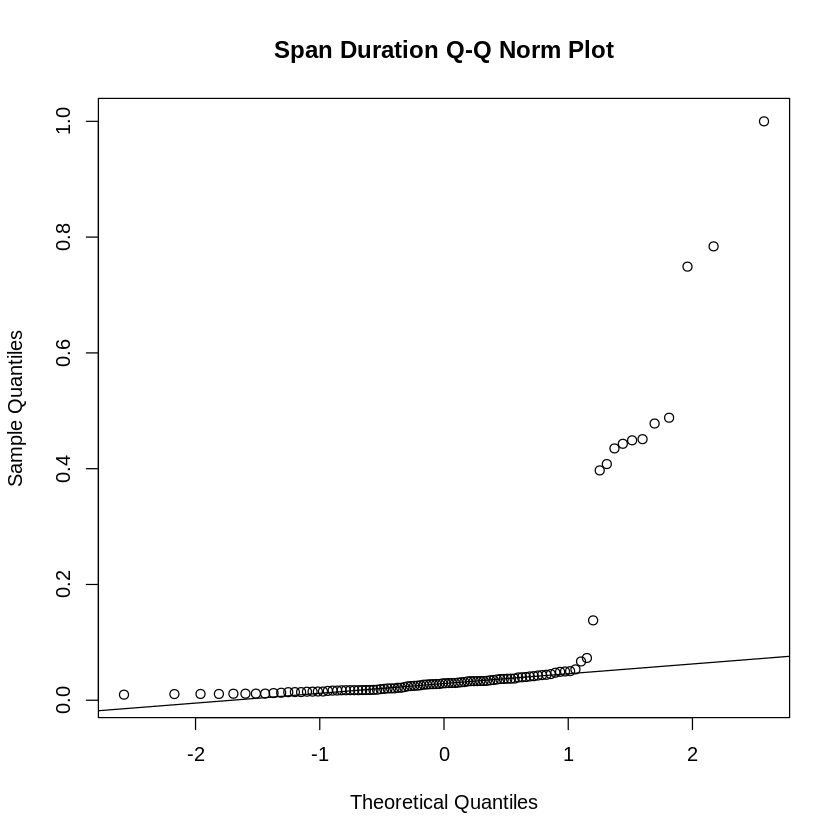

In [31]:
qqnorm(spanMetrics$Duration,main="Span Duration Q-Q Norm Plot")
qqline(spanMetrics$Duration)

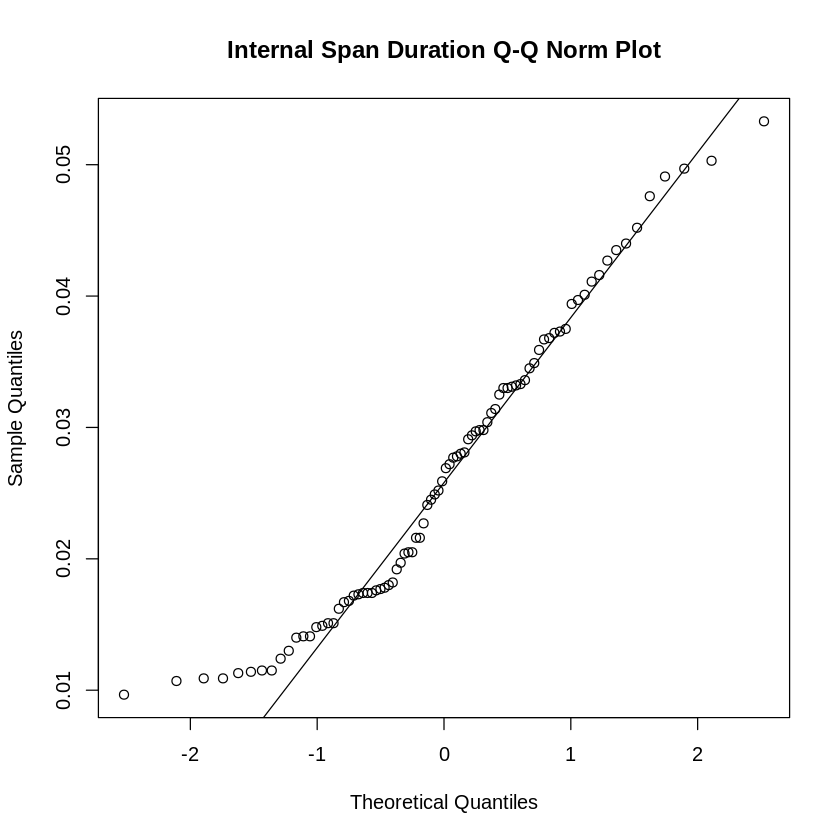

In [32]:
qqnorm(iSpan$Duration,main="Internal Span Duration Q-Q Norm Plot")
qqline(iSpan$Duration)

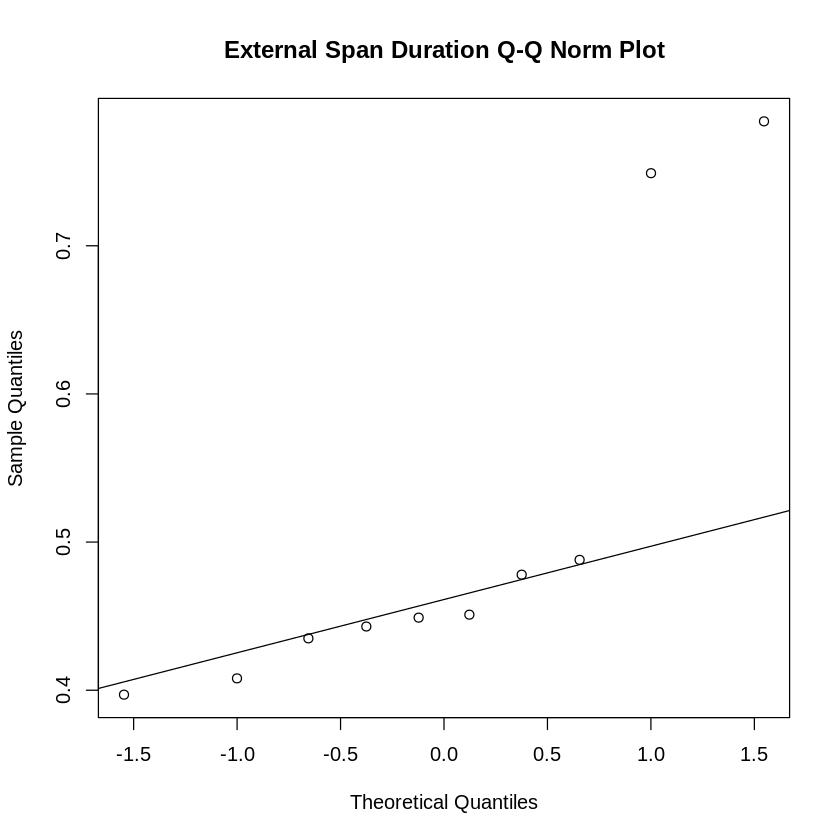

In [33]:
qqnorm(eSpan$Duration,main="External Span Duration Q-Q Norm Plot")
qqline(eSpan$Duration)

## Autocorrelation ##

Autocorrelation plots are a commonly-used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

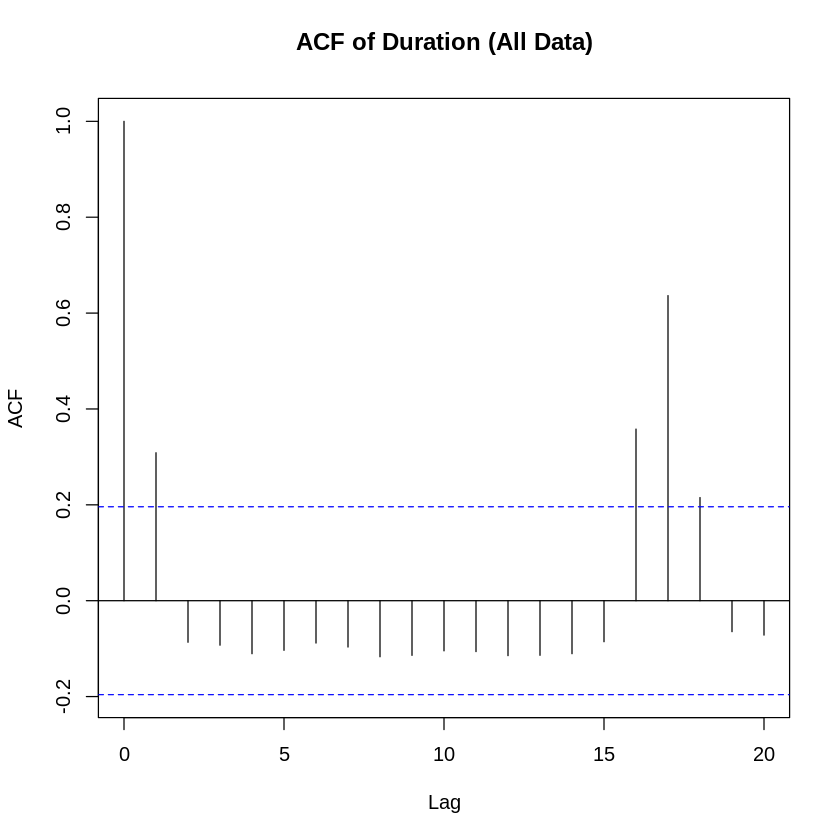

In [34]:
acf(spanMetrics$Duration, main="ACF of Duration (All Data)")

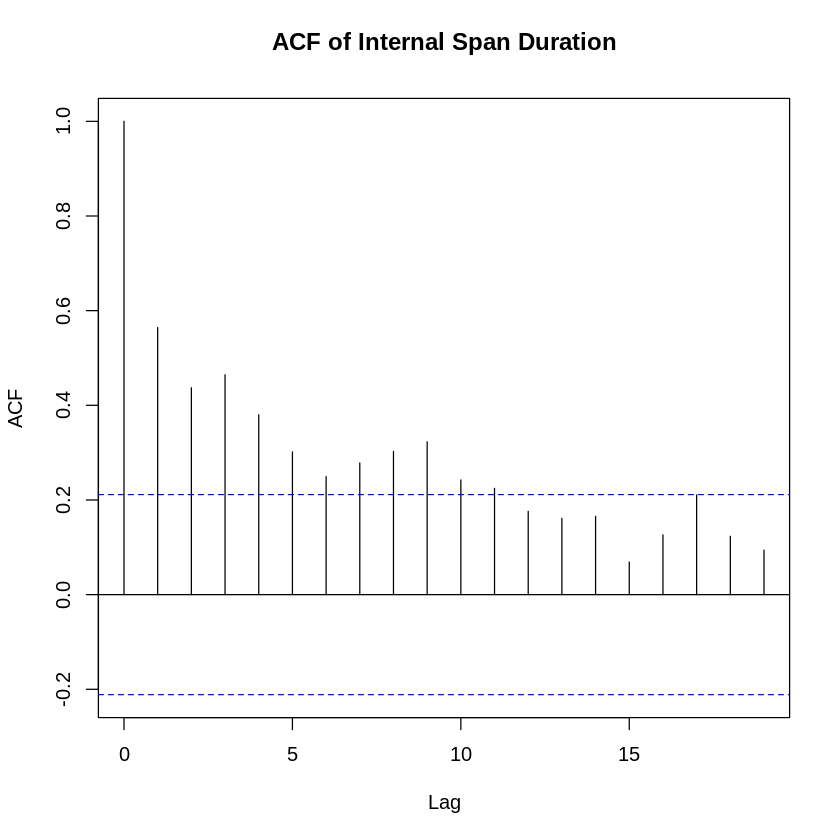

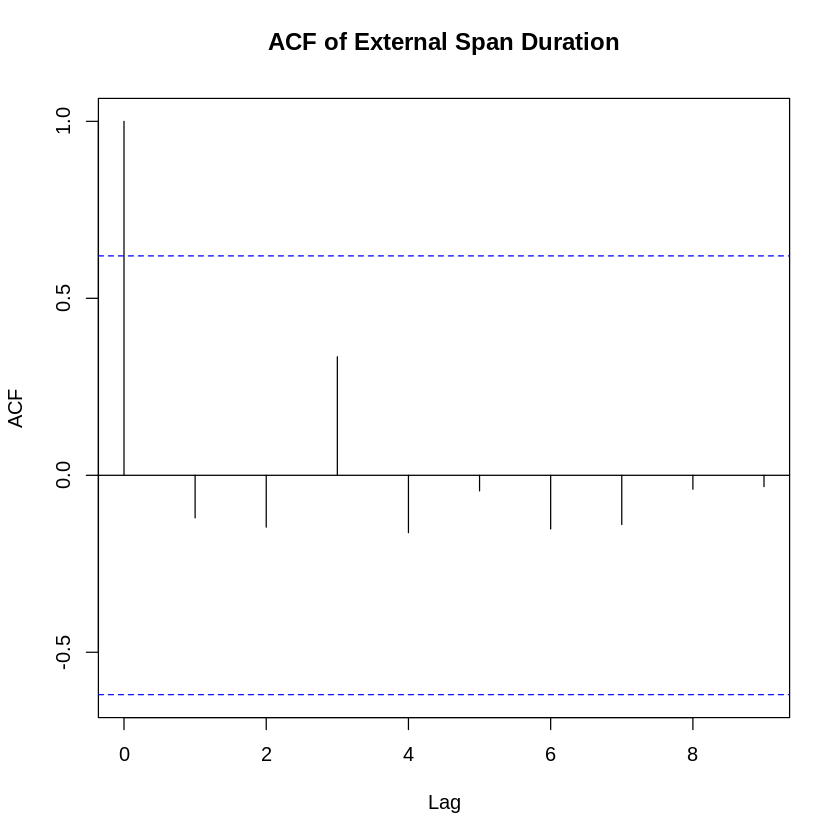

In [35]:
acf(iSpan$Duration, main="ACF of Internal Span Duration")
acf(eSpan$Duration, main="ACF of External Span Duration")

# Hypothesis Testing # 

Modern DevSecOps architectures can be designed to meet hard-real-time latency (μ) requirements using modern computing environments and computing infrastructure:

H0: μ ≤ tbd ms with jitter within latency bounds  
Ha: μ > tbd ms with jitter exceeding latency bounds  
∝ = 0.05

We will use 500 ms; i.e. tbd will be set to 0.5.



## T-Test ##

The t-test is any statistical hypothesis test in which the test statistic follows a Student's t-distribution under the null hypothesis.

A t-test is the most commonly applied when the test statistic would follow a normal distribution if the value of a scaling term in the test statistic were known. When the scaling term is unknown and is replaced by an estimate based on the data, the test statistics (under certain conditions) follow a Student's t distribution. The t-test can be used, for example, to determine if the means of two sets of data are significantly different from each other.

https://en.wikipedia.org/wiki/Student%27s_t-test

In [36]:
x = spanMetrics$Duration
t.test(x=x, mu=0.5, alternative = 'greater')


	One Sample t-test

data:  x
t = -23.333, df = 99, p-value = 1
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 0.05705404        Inf
sample estimates:
mean of x 
0.0864806 


In [37]:
x = iSpan$Duration
t.test(x=x, mu=0.5, alternative = 'greater')


	One Sample t-test

data:  x
t = -388.76, df = 85, p-value = 1
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 0.02458035        Inf
sample estimates:
 mean of x 
0.02660535 


In [38]:
x = eSpan$Duration
t.test(x=x, mu=0.5, alternative = 'greater')


	One Sample t-test

data:  x
t = 0.18641, df = 9, p-value = 0.4281
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 0.4275612       Inf
sample estimates:
mean of x 
   0.5082 


In [39]:
# ?t.test